In [4]:
logging_file_dict = {
    "distilbert agnews":
        {
        "FP16":"./distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_1000_numerical.log",
        'INT8':'./distilbert_agnews/fedFwd_distilbert_agnews_lr0.01_client_num_1000_numerical_int8.log',
}
}

train_time_dict_dict = {
    "distilbert":{"FP16":0.3085584,'INT8':0.3085584/3},
    
}


local_data_num_dict = {"agnews":15,"yahoo":18,"yelp-p":65}

In [7]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np

def plot_end_to_end(model,dataset,target_acc, path=f"/data/wyz/ForwardFL-Latex/figs"):
    logging_file = logging_file_dict[f"{model} {dataset}"]
    train_time_dict = train_time_dict_dict[model]
    local_data_num = local_data_num_dict[dataset]

    comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 
    time_to_acc_dict ={}
    
    eval_frequence = 5 if dataset == "yahoo" else 1
    linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
    colors=['r','g','b','y','c','m','k',"tan"] * 100
    lw = 3

    def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
        train_time = train_time_dict[method]
        if adhoc == None:
            adhoc = [1,1,1]
        else:
            adhoc = list(map(int,adhoc.split(",")))
        time_list = [0]
        # if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
        print(f"train time: {(train_time*local_data_num*adhoc[0])},comm_time{ (comm_time*local_data_num)}")
        # else:
        #     time = (train_time*local_data_num*adhoc[0] + 2*comm_time*local_data_num)/60
        time_list.append(time)
        for i in range(2,round):
            v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
            # if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
            # else:
            #     time += (train_time*local_data_num*v_num*eval_frequence + 2*comm_time*local_data_num)/60
            time_list.append(time)
        return time_list
        
    def get_time_to_target_acc(target_acc,acc_list,time_list):
        n = len(acc_list)
        i = 0
        while i < n and acc_list[i] < target_acc:
            i += 1
        return time_list[i] if i<n else 10000

    for i,method in enumerate(logging_file):
        file = logging_file[method]
        with open(file) as f:
            max_acc = 0
            for line in f:
                if "Trainable" in line:
                    param_num = int(line[line.rfind(":")+2:-2])
                    print(f"param_num: {param_num}")
                    break
            comm_time = param_num * 4 / comm_bandwidth
            if method == 'INT8':
                comm_time = param_num * 2 / comm_bandwidth
                
            acc = [0]
            if "," in file:
                adhoc = file.split("_")[-1].split(".")[0]
            else:
                adhoc = None
            for line in f:
                if "'acc':" in line:
                    cur_acc = float(line[line.rfind("'acc':")+7:line.rfind(",")])
                    if cur_acc > max_acc:
                        max_acc = cur_acc
                    else:
                        cur_acc = max_acc
                    acc.append(cur_acc)
            time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
            time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
    
            plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
    
    print(f"time to target acc {target_acc}: {time_to_acc_dict}")

    plt.xlabel("Time",fontsize=20)
    plt.ylabel("Acc.",fontsize=20)
    plt.xticks(size = 20)
    plt.xlim(0,10)
    plt.yticks(size = 20)
    plt.ylim(0,0.98)
    plt.legend(fontsize=20,loc=5)
    plt.title(f"{model} {dataset}",fontsize=30)
    plt.savefig(f"/data/wyz/ForwardFL-Latex/figs/eval-quant.pdf", bbox_inches="tight")
    # plt.show()

    # # 提取键和值的列表
    # keys = list(time_to_acc_dict.keys())
    # values = list(time_to_acc_dict.values())

    # # 绘制柱状图
    # plt.bar(keys, values)

    # # 设置坐标轴标签和标题
    # plt.xlabel('method')
    # plt.ylabel(f'time to target acc {target_acc}')
    # plt.title('Bar Chart')

    # 显示图形
    # plt.savefig(f"{path}/eval-bar-e2e-{model}-{dataset}.pdf", bbox_inches="tight")
    # plt.show()
    return time_to_acc_dict

param_num: 450340
train time: 4.628376,comm_time20.61492919921875
param_num: 450340
train time: 1.5427920000000002,comm_time10.307464599609375
time to target acc 0.85: {'FP16': 7.152269806445309, 'INT8': 4.147589809863283}


{'FP16': 7.152269806445309, 'INT8': 4.147589809863283}

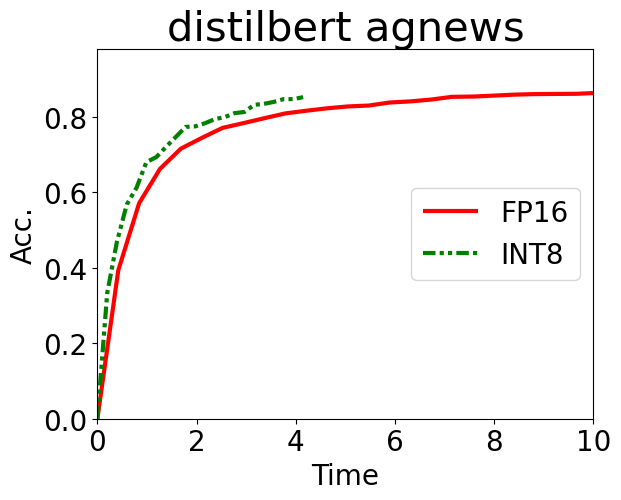

In [14]:
plot_end_to_end('distilbert','agnews',0.85)

In [26]:
models = ['albert','distilbert','bert','roberta-large']
datasets = ['agnews','yahoo','yelp-p']
acc_threhold = {
    'albert-agnews': 0.875,
    'distilbert-agnews':0.875,
    'bert-agnews':0.875,
    'roberta-large-agnews':0.875,
    'albert-yahoo':0.65,
    'distilbert-yahoo':0.7,
    'bert-yahoo':0.69,
    'roberta-large-yahoo':0.65,
    'albert-yelp-p':0.82,
    'distilbert-yelp-p':0.82,
    'bert-yelp-p':0.83,
    'roberta-large-yelp-p':0.82
}
runtime = {}
for model in models:
    for dataset in datasets:
        runtime.update({f"{model}-{dataset}": plot_end_to_end(model,dataset,acc_threhold[f"{model}-{dataset}"])})

param_num: 13188
param_num: 2228
param_num: 27652
param_num: 13188
param_num: 11686660
time to target acc 0.875: {'ours': 40.27687773942623, 'fedadapter': 32.582560572130895, 'adapter': 31.213490124932658, 'bitfit': 31.24320617254854, 'full': 3847.686815690657}
param_num: 17802
param_num: 2690
param_num: 32266
param_num: 17802
param_num: 11691274
time to target acc 0.65: {'ours': 54.905402279094815, 'fedadapter': 52.34481558964172, 'adapter': 89.5192322652882, 'bitfit': 61.12376629344022, 'full': 592.9927411856816}
param_num: 11650
param_num: 4073
param_num: 26114
param_num: 11650
param_num: 11685122
time to target acc 0.82: {'ours': 48.00385027963926, 'fedadapter': 51.15817834262189, 'adapter': 175.2167934430001, 'bitfit': 65.31686857938216, 'full': 4912.770394504591}
param_num: 450340
param_num: 152164
param_num: 450340
param_num: 54532
param_num: 66365956
time to target acc 0.875: {'ours': 25.396006455414874, 'fedadapter': 14.892142973801192, 'adapter': 42.464438956425134, 'bitfit':

In [31]:
import numpy as np
max([v['adapter']/v['ours'] for k,v in runtime.items()])

39.11338500356597

In [23]:
sum([v['fedadapter']>v['ours'] for k,v in runtime.items()])

1

In [15]:
np.mean([max(v['adapter'],v['bitfit'])/v['ours'] for k,v in runtime.items()])

19.217501072693462

In [44]:
np.mean([v['fedadapter']/v['ours'] for k,v in runtime.items()])

0.8303159899991366

param_num: 13188
param_num: 2228
param_num: 27652
param_num: 13188
param_num: 11686660
time to target acc 0.875: {'ours': 227.1342404980467, 'fedadapter': 187.75497436523455, 'adapter': 168.2788970214845, 'bitfit': 174.8355372070312, 'full': 4598.2830915527375}


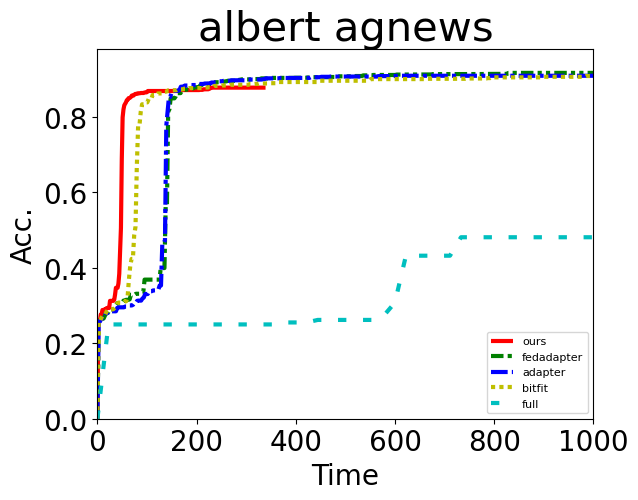

param_num: 17802
param_num: 2690
param_num: 32266
param_num: 17802
param_num: 11691274
time to target acc 0.65: {'ours': 315.9479269687499, 'fedadapter': 303.103436279297, 'adapter': 509.8531467480471, 'bitfit': 350.9191980175783, 'full': 1075.9851273925785}


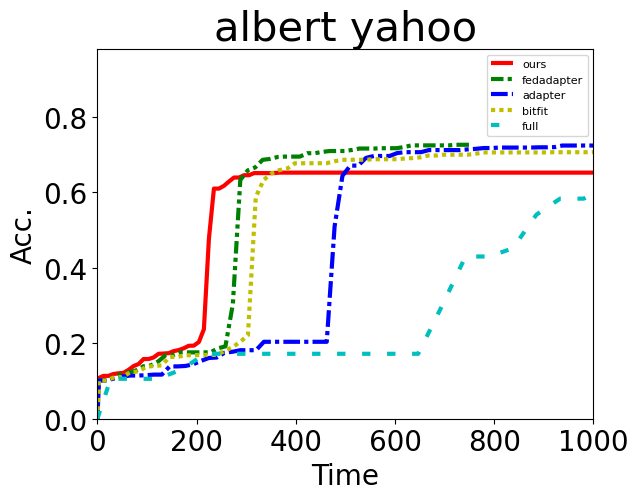

param_num: 11650
param_num: 4073
param_num: 26114
param_num: 11650
param_num: 11685122
time to target acc 0.82: {'ours': 271.58193855550115, 'fedadapter': 293.2271438598634, 'adapter': 948.2946968912769, 'bitfit': 367.0058065104167, 'full': 5871.261291056319}


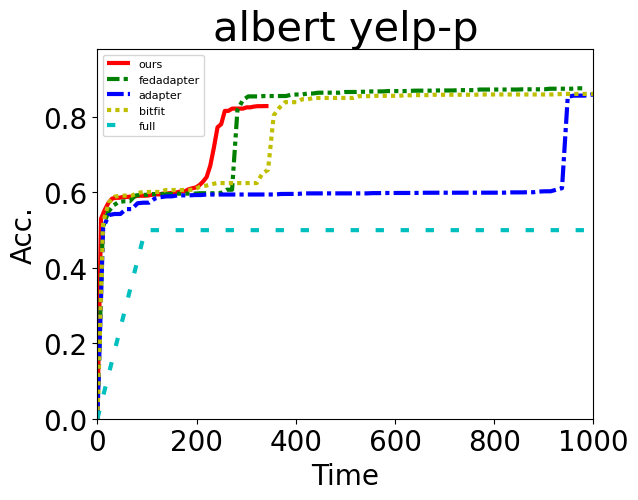

param_num: 450340
param_num: 152164
param_num: 450340
param_num: 54532
param_num: 66365956
time to target acc 0.875: {'ours': 61.53873197265625, 'fedadapter': 29.535825732421834, 'adapter': 84.67270102539067, 'bitfit': 76.43602753906247, 'full': 721.0081364746094}


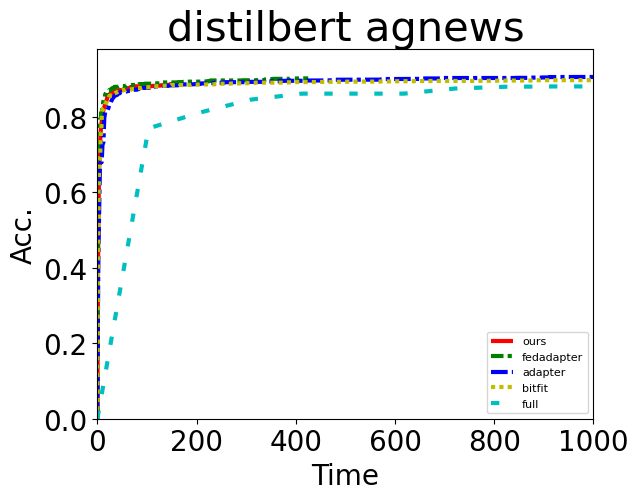

param_num: 454954
param_num: 156778
param_num: 454954
param_num: 59146
param_num: 66370570
time to target acc 0.7: {'ours': 110.53740537011724, 'fedadapter': 59.92263638671878, 'adapter': 115.33239612304688, 'bitfit': 134.77871033203127, 'full': 651.3564165527343}


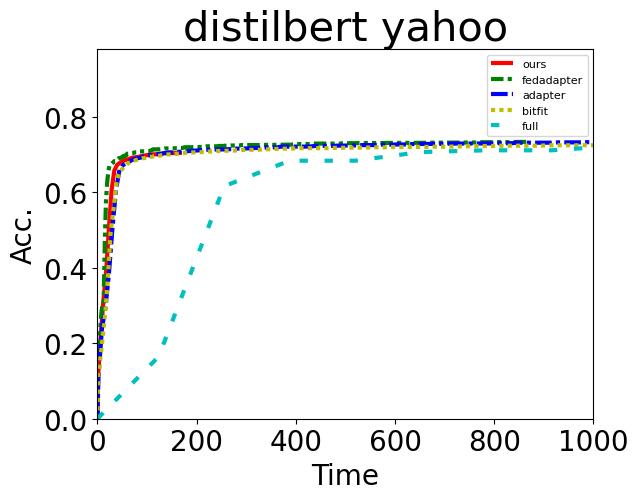

param_num: 448802
param_num: 150626
param_num: 448802
param_num: 52994
param_num: 66364418
time to target acc 0.82: {'ours': 92.21657269042969, 'fedadapter': 52.487620288085935, 'adapter': 119.64628033854164, 'bitfit': 116.65809238281248, 'full': 892.6564014485677}


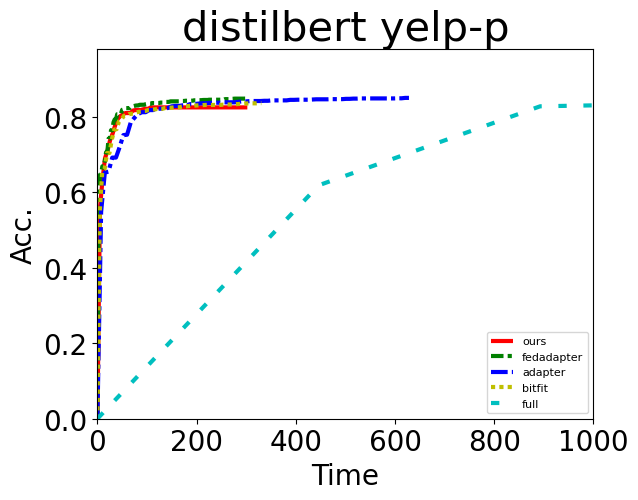

param_num: 105988
param_num: 152164
param_num: 897604
param_num: 105988
param_num: 109485316
time to target acc 0.875: {'ours': 200.74820937011702, 'fedadapter': 89.53831054687491, 'adapter': 250.06223071289043, 'bitfit': 272.7647819824218, 'full': 1535.1577580566407}


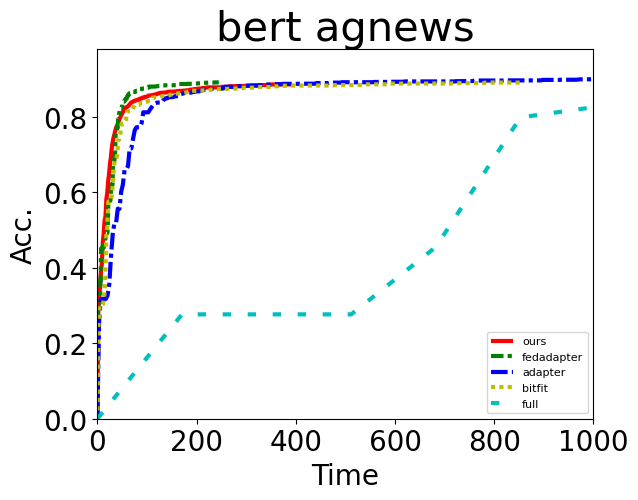

param_num: 110602
param_num: 156778
param_num: 902218
param_num: 110602
param_num: 109489930
time to target acc 0.69: {'ours': 462.7373979873052, 'fedadapter': 176.1896743652345, 'adapter': 311.8387914550781, 'bitfit': 366.26484931640636, 'full': 1090.9063478027342}


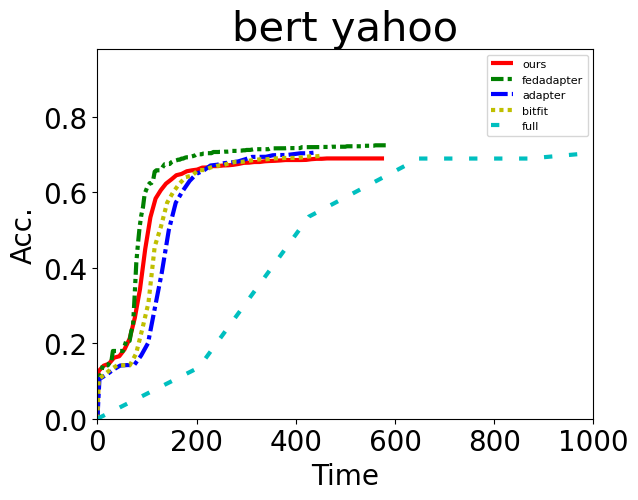

param_num: 104450
param_num: 150626
param_num: 896066
param_num: 104450
param_num: 109483778
time to target acc 0.83: {'ours': 242.78990580973328, 'fedadapter': 212.7284548339844, 'adapter': 370.84268086751285, 'bitfit': 307.18175651041673, 'full': 2217.4195865478514}


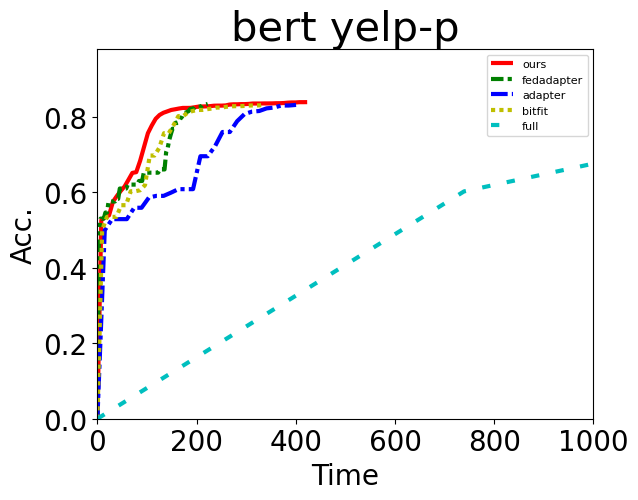

param_num: 275460
param_num: 532740
param_num: 3175940
param_num: 275460
param_num: 354314244
time to target acc 0.875: {'ours': 194.27252299316427, 'fedadapter': 26.96740611328124, 'adapter': 859.9535859375003, 'bitfit': 58.91689184570313, 'full': 3833.6489177246094}


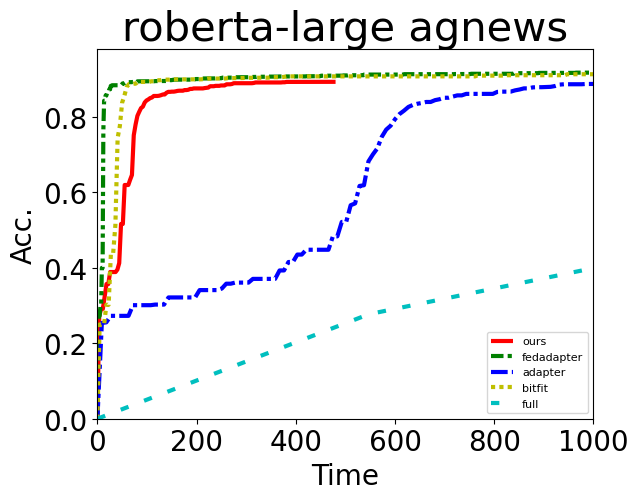

param_num: 281610
param_num: 538890
param_num: 3182090
param_num: 281610
param_num: 354320394
time to target acc 0.65: {'ours': 277.27401517382805, 'fedadapter': 10000, 'adapter': 132.7490040527344, 'bitfit': 131.38045986328123, 'full': 10000}


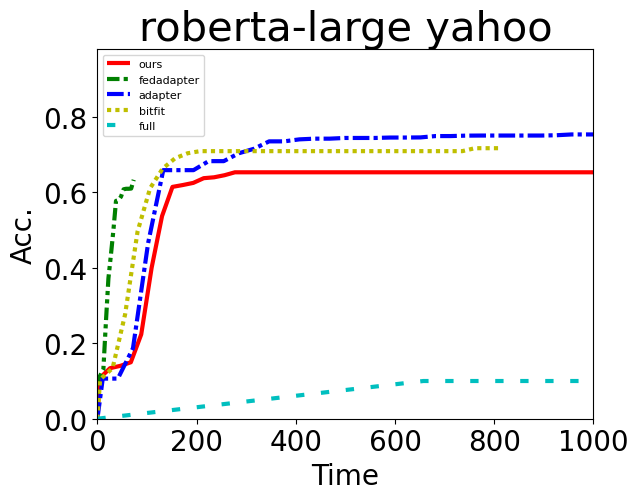

param_num: 273410
param_num: 530690
param_num: 3173890
param_num: 273410
param_num: 354312194
time to target acc 0.82: {'ours': 95.26283717285158, 'fedadapter': 123.0933702197266, 'adapter': 1319.329012125652, 'bitfit': 196.25409057617188, 'full': 66449.53503694663}


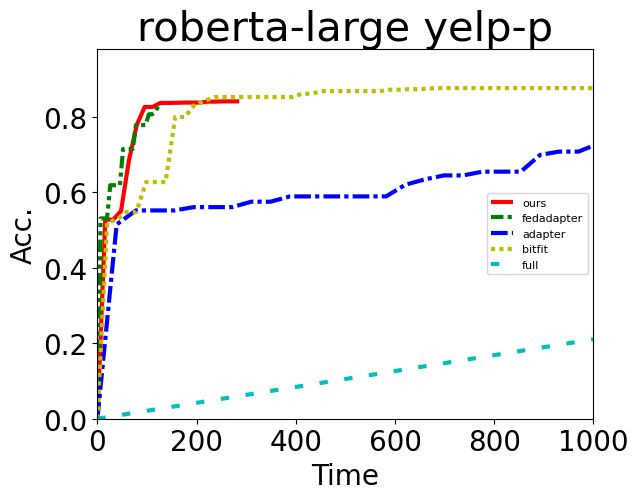

In [9]:
models = ['albert','distilbert','bert','roberta-large']
datasets = ['agnews','yahoo','yelp-p']
acc_threhold = {
    'albert-agnews': 0.875,
    'distilbert-agnews':0.875,
    'bert-agnews':0.875,
    'roberta-large-agnews':0.875,
    'albert-yahoo':0.65,
    'distilbert-yahoo':0.7,
    'bert-yahoo':0.69,
    'roberta-large-yahoo':0.65,
    'albert-yelp-p':0.82,
    'distilbert-yelp-p':0.82,
    'bert-yelp-p':0.83,
    'roberta-large-yelp-p':0.82
}
runtime = {}
for model in models:
    for dataset in datasets:
        runtime.update({"f{model}-{dataset}": plot_end_to_end(model,dataset,acc_threhold[f"{model}-{dataset}"])})